In [527]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Sensing/'
num_cores = -1 #number of cores for parallelization

# System parameters for periodic boundary condition spin chain
J = 1.0  # +ve is Ferromagnet [Hamiltonian as defined Mishra, Bayat, PRL 127, 080504 (2021)]
gamma = 1.0
sites = 100
h1_amp = 1.5 #amplitude of the drive
h1_period = 1.0 #period of the drive

# Initial state
initial_state = 'ground_state' 
# 'ground_state': starts in the system ground-state. 
# 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
# 'momentum': a k = 0 momentum state. Even parity = PBC.
# 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Boundary conditions
boundary_conditions = 'PBC' 
# 'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions
# The boundary conditions must reflect the fermion parity in the initial conditions (see above).
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.

# Time parameters (results returned at these times)
dt = 0.0001 # time step
oneperiod_steps = int(h1_period/dt) # number of steps in one period
final_time = 1000 # time in stroboscopic units

# Sensing parameters
phasepoints = 1 # number of points for calculating h0
h0mat = np.linspace(0.9, 0.9, phasepoints)  # range of h0 points to sample
sub_system = 4 # range of subsystem sizes for evaluating Fisher information

# Computational for Fisher information (with 4th order derivate approximation)
tol = 10**(-8) # when evaluating the Fisher information we don't consider singular terms for which |w[rr] + w[ss]| < tol 
shift = 10**(-5) # finite division size for calculating derivative of reduced density matrix, i.e. drho/dh0 ~ (rho(h0) - rho(h0 + shift))/shift for the order2 version

# Initialize the periodic field
h1 = h1_amp*np.sin(2*np.pi/(h1_period)*dt*np.arange(0,oneperiod_steps)) # initialize periodic field


Calculate the eigenvalues and state of the Floquet unitary

In [528]:
# Calculate state after 1 period starting from a basis state. This is used to build Floquet unitary.

h0 = h0mat[0]
Fisher_mat = []
particle_number = []
quasi_energy = []
initial_state_list = []
eval_list = []
evec_list = []

basis_state = []
for kk in range(0,sites):

    basis_state = basis_state + [np.asarray([1,0])] #basis state is up (occupied state), initial down-state used in method


for pp in range(0,5):

    print(pp)

    method = 'RK4' # integration method 'heun' or 'RK4'
    h1_midpoint = h1_amp*np.sin(2*np.pi/(h1_period)*dt*(0.5 + np.arange(0,oneperiod_steps))) # vector at the mid-point between time-steps, required for RK4 due to explicit time-dependance
    state = methods.integrator_BdG(J, gamma, h0 - 2*shift + shift*pp, h1, h1_midpoint, oneperiod_steps, dt, sites, boundary_conditions, basis_state, method)

    #state = methods.integrate_bdg_eff(basis_state, h1_amp, h1_period, J, gamma,  h0 - 2*shift + shift*pp, dt, oneperiod_steps, sites, boundary_conditions)
    # Initial state is a list of vectors (u_k,v_k) 
    # Build the Floquet unitary and calculate eigenvalues, eigenvectors in this basis
    eval, evec = methods.floquet_eigsystem(state)

    print('Eigensystem evaluated')

    # Calculate the initial ground-state

    initial_state = methods.initial_BdG(J, gamma, h0 - 2*shift + shift*pp, h1, sites, boundary_conditions)

    initial_state_list = initial_state_list + [initial_state]

    eval_list = eval_list + [eval]

    evec_list = evec_list + [evec]


eval_list = np.array(eval_list)
evec_list = np.array(evec_list)
initial_state_list = np.array(initial_state_list)


def floquet_evolution_eff_vectorized(final_time, sites, boundary_conditions, evals, evecs, initial_states):
    """
    evals: shape (pp, sites, 2) complex eigenvalues for each pp, k, band
    evecs: shape (pp, sites, 2, 2) eigenvectors for each pp, k, band, component
    initial_states: shape (pp, sites, 2) initial BdG spinors
    """

    # Calculate overlaps ov0 and ov1 for all pp, sites at once:
    # ov0[pp, k] = <evecs[pp,k,:,0] | initial_states[pp,k,:]>
    ov0 = np.sum(np.conj(evecs[..., :, 0]) * initial_states, axis=-1)  # shape (pp, sites)
    ov1 = np.sum(np.conj(evecs[..., :, 1]) * initial_states, axis=-1)  # shape (pp, sites)

    # Raise eigenvalues to final_time power:
    evals_t0 = evals[..., 0] ** final_time  # shape (pp, sites)
    evals_t1 = evals[..., 1] ** final_time  # shape (pp, sites)

    # Construct final_state for all pp,k:
    # final_state[pp, k, :] = evals_t0 * ov0 * evec[:, :, 0] + evals_t1 * ov1 * evec[:, :, 1]
    final_state = (
        (evals_t0[..., np.newaxis] * ov0[..., np.newaxis]) * evecs[..., :, 0]
        + (evals_t1[..., np.newaxis] * ov1[..., np.newaxis]) * evecs[..., :, 1]
    )  # shape (pp, sites, 2)

    # Determine k vector:
    if boundary_conditions == 'PBC':
        kval = -np.pi + 2 * np.arange(sites) * np.pi / sites
    elif boundary_conditions == 'ABC':
        kval = -np.pi + (2 * np.arange(sites) + 1) * np.pi / sites
    else:
        raise ValueError("Unsupported boundary condition")

    # Compute k-space observables:
    obs_kspace = np.abs(final_state[..., 0]) ** 2   # shape (pp, sites)
    Dag_obs_kspace = np.conj(final_state[..., 0]) * final_state[..., 1]  # shape (pp, sites)

    # Fourier transform obs and Dag_obs back to real space for each pp:
    # Use broadcasting and einsum or matrix multiplication for speed.

    # Phase factor: shape (sites, sites)
    m = np.arange(sites)[:, None, None]
    n = np.arange(sites)[None, :, None]
    k = kval[None, None, :]
    phase = np.exp(-1j * (m - n) * k) / sites
    # To handle shape, do for each pp:
    # obs[pp,m,n] = sum_k phase[m,n,k] * obs_kspace[pp,k]
    # Similarly for Dag_obs

    # But phase shape is (sites, sites, sites), which can be large. So use einsum smartly:

    # Reshape phase for einsum: (m,n,k)
    # obs_kspace: (pp, k)
    # output obs: (pp, m, n)
    obs = np.einsum('mnk,pk->pmn', phase, obs_kspace)
    Dag_obs = np.einsum('mnk,pk->pmn', phase, Dag_obs_kspace)

    # Return obs, Dag_obs, and evals
    return obs, Dag_obs, evals

Fisher_mat = []
particle_number = []

for time in range(0,final_time):
    print(f"time step: {time}")

    obs, Dag_obs, _ = floquet_evolution_eff_vectorized(
        time,
        sites,
        boundary_conditions,
        eval_list,         # shape (pp, sites, 2)
        evec_list,         # shape (pp, sites, 2, 2)
        initial_state_list  # shape (pp, sites, 2)
    )

    Gamma_list = []
    for pp in range(obs.shape[0]):  # pp dimension
        Gamma_mat = methods.fermion_to_Majorana(obs[pp], Dag_obs[pp], sub_system)
        Gamma_list.append(Gamma_mat)

    Fisher = methods.Fisher_from_Gamma(Gamma_list, shift, tol, sub_system)
    Fisher_mat.append(Fisher)

    # For particle number, e.g. average over pp or pick one:
    particle_number.append(np.mean(obs[:, 0, 0]))


0
Eigensystem evaluated
1
Eigensystem evaluated
2
Eigensystem evaluated
3
Eigensystem evaluated
4
Eigensystem evaluated
time step: 0
avoid singularity index 0
time step: 1
avoid singularity index 0
time step: 2
avoid singularity index 0
time step: 3
avoid singularity index 0
time step: 4
avoid singularity index 0
time step: 5
avoid singularity index 0
time step: 6
avoid singularity index 0
time step: 7
avoid singularity index 0
time step: 8
avoid singularity index 0
time step: 9
avoid singularity index 0
time step: 10
avoid singularity index 0
time step: 11
avoid singularity index 0
time step: 12
avoid singularity index 0
time step: 13
avoid singularity index 0
time step: 14
avoid singularity index 0
time step: 15
avoid singularity index 0
time step: 16
avoid singularity index 0
time step: 17
avoid singularity index 0
time step: 18
avoid singularity index 0
time step: 19
avoid singularity index 0
time step: 20
avoid singularity index 0
time step: 21
avoid singularity index 0
time step:

In [531]:
np.save('Results_Floquet/Fisher_mat_'+str(sites)+'_test_h_'+str(h0)+'.npy',Fisher_mat)
np.save('Results_Floquet/final_time_'+str(sites)+'_test_h_'+str(h0)+'.npy',final_time)
# np.save('Results_Floquet/h0mat_100_dtM3.npy',h0mat)
# np.save('Results_Floquet/particle_number_100_dtM3.npy',particle_number)


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


ValueError: x and y must have same first dimension, but have shapes (100,) and (1000,)

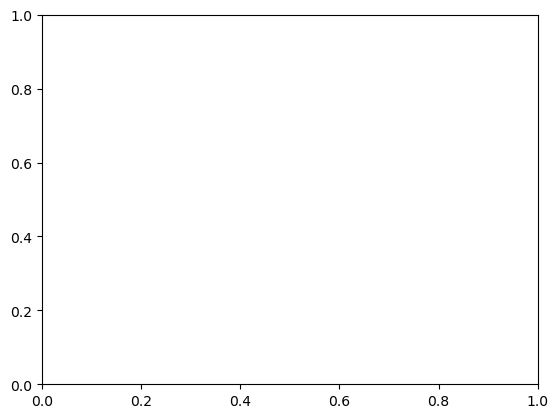

In [530]:
plt.plot(h1_period*np.arange(0,final_time,10),np.log10(Fisher_mat),'k')
plt.xlabel(r"$n\tau$")
plt.show()

print(Fisher_mat)